In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Define Data Transformations (Normalization & Augmentation)
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(0, shear=15, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 Dataset
batch_size = 64
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

# Class names
classes = ["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]


Files already downloaded and verified
Files already downloaded and verified


In [38]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Reduce size by half (16x16)

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Reduce size by half (8x8)

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)   # Reduce size by half (4x4)
        )

        # Dynamically compute the input features for the first linear layer
        self.flatten_size = self._get_conv_output_size()

        self.fc_layers = nn.Sequential(
            nn.Linear(self.flatten_size, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            
            nn.Linear(256, 10)  # 10 output classes for CIFAR-10
        )

    def _get_conv_output_size(self):
        """Compute the output size after convolutions to correctly set up the FC layer."""
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 32, 32)  # CIFAR-10 input size (1 sample)
            output = self.conv_layers(dummy_input)
            return output.view(1, -1).size(1)  # Flatten and get size

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten dynamically
        x = self.fc_layers(x)
        return x

In [39]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)  # Reduce LR every 10 epochs
epochs = 50
train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    scheduler.step()  # Reduce learning rate over time

    train_losses.append(running_loss / len(trainloader))

    # Evaluate on Test Set
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_losses.append(test_loss / len(testloader))
    test_accuracy = correct / total

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f} - Test Loss: {test_losses[-1]:.4f} - Test Accuracy: {test_accuracy:.4f}")


Epoch 1/50 - Train Loss: 1.6603 - Test Loss: 1.3236 - Test Accuracy: 0.5051
Epoch 2/50 - Train Loss: 1.2821 - Test Loss: 1.1025 - Test Accuracy: 0.6113
Epoch 3/50 - Train Loss: 1.1058 - Test Loss: 0.9631 - Test Accuracy: 0.6682
Epoch 4/50 - Train Loss: 0.9938 - Test Loss: 0.8482 - Test Accuracy: 0.7008
Epoch 5/50 - Train Loss: 0.9125 - Test Loss: 0.8054 - Test Accuracy: 0.7217
Epoch 6/50 - Train Loss: 0.8350 - Test Loss: 0.6689 - Test Accuracy: 0.7682
Epoch 7/50 - Train Loss: 0.7732 - Test Loss: 0.6668 - Test Accuracy: 0.7696
Epoch 8/50 - Train Loss: 0.7161 - Test Loss: 0.6024 - Test Accuracy: 0.8008
Epoch 9/50 - Train Loss: 0.6717 - Test Loss: 0.6410 - Test Accuracy: 0.7949
Epoch 10/50 - Train Loss: 0.6293 - Test Loss: 0.5278 - Test Accuracy: 0.8268
Epoch 11/50 - Train Loss: 0.5212 - Test Loss: 0.4510 - Test Accuracy: 0.8526
Epoch 12/50 - Train Loss: 0.4944 - Test Loss: 0.4571 - Test Accuracy: 0.8501
Epoch 13/50 - Train Loss: 0.4650 - Test Loss: 0.4311 - Test Accuracy: 0.8549


KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (50,) and (14,)

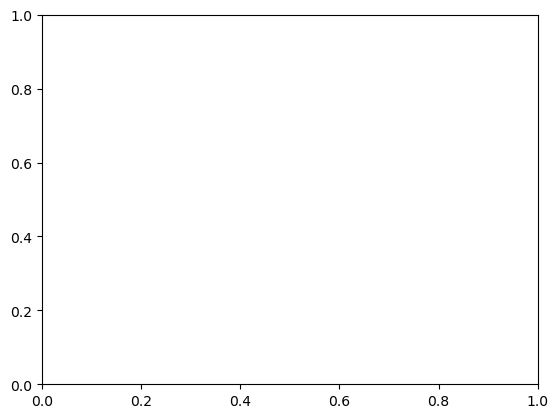

In [40]:
plt.plot(range(epochs), train_losses, label="Train Loss")
plt.plot(range(epochs), test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs. Test Loss")
plt.show()

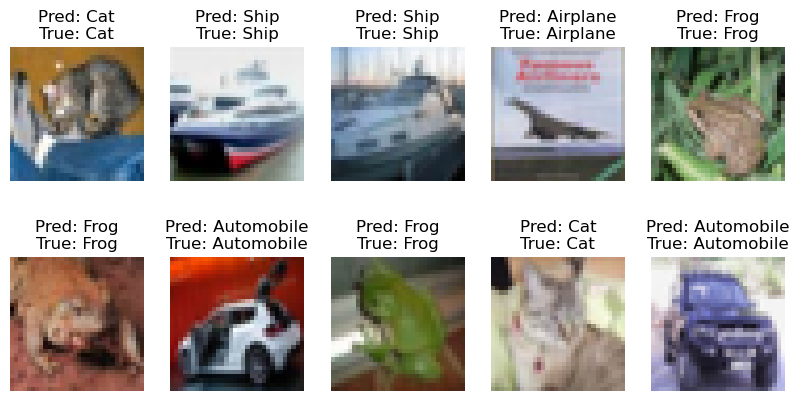

In [ ]:
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")

# Get random test images
dataiter = iter(testloader)
images, labels = next(dataiter)

# Predict
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Show Images with Predictions
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    imshow(images[i].cpu())
    plt.title(f"Pred: {classes[predicted[i]]}\nTrue: {classes[labels[i]]}")
    plt.axis("off")
plt.show()

In [ ]:
def evaluate_accuracy(model, testloader, device):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation for faster inference
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)  # Move to device (MPS/CPU)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Get class with highest probability
            correct += (predicted == labels).sum().item()  # Count correct predictions
            total += labels.size(0)

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [ ]:
evaluate_accuracy(model, testloader, device)

Test Accuracy: 84.46%


84.46

In [3]:
import tensorflow as tf

# Enable GPU Memory Growth (Prevents Out-of-Memory Errors)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is enabled")
    except RuntimeError as e:
        print(e)

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models, datasets

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize data

# Define the ANN model
ann = models.Sequential([
    layers.Flatten(input_shape=(32, 32, 3)),
    layers.Dense(3000, activation='relu'),
    layers.Dense(1000, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile the model
ann.compile(optimizer='SGD',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

# Check GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Enable GPU memory growth (prevents TensorFlow from consuming all memory)
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ Training on GPU:", gpus)
    except RuntimeError as e:
        print("❌ Error:", e)

# Train the model on GPU
with tf.device('/GPU:0'):
    ann.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.3033 - loss: 1.9405 - val_accuracy: 0.4025 - val_loss: 1.7074
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.4220 - loss: 1.6427 - val_accuracy: 0.4253 - val_loss: 1.6127
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - accuracy: 0.4546 - loss: 1.5536 - val_accuracy: 0.4101 - val_loss: 1.6276
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.4745 - loss: 1.4871 - val_accuracy: 0.4716 - val_loss: 1.4860
Epoch 5/5
 307/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.4836 - loss: 1.4688

KeyboardInterrupt: 